# Mantle convection

This code is taken from a chapter in [The FEniCS Book](https://fenicsproject.org/book/), which is available for free online.
That chapter is in turn an implementation of a model setup from [van Keken et al (1997)](https://doi.org/10.1029/97JB01353).
I took just the thermomechanical parts and removed the chemistry.
This paper and the code from the FEniCS book all use a non-dimensional form of the equations, which I've adopted here.

In this notebook, we'll see the Stokes equations again, but we'll couple them to the evolution of temperature.
The temperature evolution is an advection-diffusion equation.
Remember that the extensive quantity for heat transport is the internal energy density
$$G = \rho c_p T$$
where $\rho$, $c_p$ are the mass density and the specific heat at constant pressure.
The flux of heat when there is bulk movement of the medium at a velocity $u$ is
$$F = \rho c_p T u - k\nabla T.$$
There are two modes of heat transport: convection and diffusion.
It's a good question to ask whether one of them is more or less important than the other.
Remember that the thermal diffusivity
$$\alpha = \frac{k}{\rho c_p}$$
has units of length${}^2$ / time.
If we know a characteristic length scale $L$ and velocity $U$, we can then use the ratio
$$\text{Pe} = \frac{UL}{\alpha},$$
which is called the Peclet number, to tell whether convection or diffusion dominates.
When the Peclet number is large, we're in the convection-dominated regime; when it's small, we're in the diffusion-dominated regime.
For this problem, we're mostly convection-dominated.

The conservation law for heat flow is
$$\frac{d}{dt}\int_\omega \rho c_p T\;dx + \int_{\partial\omega}\left(\rho c_p T u - k\nabla T\right)\cdot\nu\;d\gamma = \int_\omega Q\;dx$$
for all control volumes $\omega$, $\nu$ is the unit outward normal to $\partial\omega$ and $Q$ are the sources of heat.
We assume here zero heat sources but you could add some from radiogenic sources or from strain heating if you like.
To turn this into a variational form, we replace integrals over $\omega$ with integrals over $\Omega$ with multiplication by a test function $\phi$, and we replace the flux integral over $\partial\omega$ with integration over all of $\Omega$ and multiplication by $\nabla\phi$:
$$\int_\Omega\left(\partial_t(\rho c_p T)\phi - \rho c_p Tu\cdot\nabla\phi + k\nabla T\cdot\nabla\phi - Q\phi\right)dx = 0$$
for all test functions $\phi$.

There is literally an entire wikipedia article on [dimensionless numbers in fluid mechanics](https://en.wikipedia.org/wiki/Dimensionless_numbers_in_fluid_mechanics).
If you do any fluid mechanics at all you have to know about the [Reynolds number](https://en.wikipedia.org/wiki/Reynolds_number).
The others that you might want to know for this problem are the [Rayleigh number](https://en.wikipedia.org/wiki/Rayleigh_number) and the [Prandtl number](https://en.wikipedia.org/wiki/Prandtl_number).

Here we're using a rectangular domain.
Again, the spatial scales have been non-dimensionalized.

In [1]:
import firedrake
from firedrake import Constant
Lx, Ly = Constant(2.0), Constant(1.0)
ny = 32
nx = int(float(Lx / Ly)) * ny
mesh = firedrake.RectangleMesh(
    nx, ny, float(Lx), float(Ly), diagonal="crossed"
)

The initial condition for temperature involves loads of annoyingly long expressions, but it's all in Appendix A of the van Keken paper.

In [2]:
import numpy as np
from numpy import pi as π
from firedrake import sqrt, exp, min_value, max_value

def clamp(z, zmin, zmax):
    return min_value(Constant(zmax), max_value(Constant(zmin), z))

def switch(z):
    return exp(z) / (exp(z) + exp(-z))

Ra = Constant(1e6)

ϵ = Constant(1 / nx)
x = firedrake.SpatialCoordinate(mesh)

q = Lx**(7 / 3) / (1 + Lx**4)**(2 / 3) * (Ra / (2 * np.sqrt(π)))**(2/3)
Q = 2 * firedrake.sqrt(Lx / (π * q))
T_u = 0.5 * switch((1 - x[1]) / 2 * sqrt(q / (x[0] + ϵ)))
T_l = 1 - 0.5 * switch(x[1] / 2 * sqrt(q / (Lx - x[0] + ϵ)))
T_r = 0.5 + Q / (2 * np.sqrt(π)) * sqrt(q / (x[1] + 1)) * exp(-x[0]**2 * q / (4 * x[1] + 4))
T_s = 0.5 - Q / (2 * np.sqrt(π)) * sqrt(q / (2 - x[1])) * exp(-(Lx - x[0])**2 * q / (8 - 4 * x[1]))
expr = T_u + T_l + T_r + T_s - Constant(1.5)

degree = 1
temperature_space = firedrake.FunctionSpace(mesh, "CG", degree)
T_0 = firedrake.Function(temperature_space).interpolate(clamp(expr, 0, 1))
T = T_0.copy(deepcopy=True)

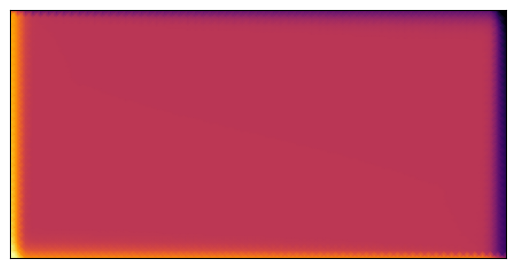

In [3]:
import matplotlib.pyplot as plt
def subplots():
    fig, axes = plt.subplots()
    axes.set_aspect("equal")
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    axes.set_xlim(0, float(Lx))
    axes.set_ylim(0, float(Ly))
    return fig, axes

fig, axes = subplots()
firedrake.tripcolor(T, cmap="inferno", axes=axes);

Next we need to make some function spaces for the fluid velocity and pressure.
Note how the degree of the velocity space is one higher than that of the pressure.
We can then combine the two together to form a *mixed* function space, which we need to do since we"re solving for both velocity and pressure at the same time.

In [4]:
pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 2)
Z = velocity_space * pressure_space

Once we've created a function in the mixed space, we can then pull out the two parts with the `split` method.

In [5]:
z = firedrake.Function(Z)
u, p = firedrake.split(z)

The variational form of the Stokes equations, hopefully familiar from before.

In [6]:
from firedrake import inner, sym, grad, div, dx, as_vector

μ = Constant(1)
def ε(u):
    return sym(grad(u))

v, q = firedrake.TestFunctions(z.function_space())

τ = 2 * μ * ε(u)
g = as_vector((0, -1))
f = -Ra * T * g
F = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx

We can use the `.sub` method to pull parts out of mixed spaces, which we need in order to create the right boundary conditions.

In [7]:
bc = firedrake.DirichletBC(Z.sub(0), as_vector((0, 0)), "on_boundary")

A bit of magic in order to tell the linear solver that the Stokes equations have a null space we need to project out.

In [8]:
basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
nullspace = firedrake.MixedVectorSpaceBasis(Z, [Z.sub(0), basis])

Here I'm not using the usual `firedrake.solve` function.
Instead, I'm creating an object that represents the problem and another the solver.
The solver object caches important information about how the system is formed and runs much faster if we have to call it repeatedly.

In [9]:
stokes_problem = firedrake.NonlinearVariationalProblem(F, z, bc)
parameters = {
    "nullspace": nullspace,
    "solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

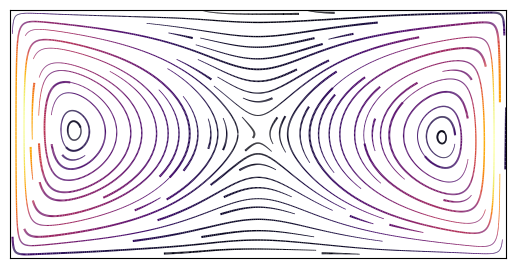

In [10]:
stokes_solver.solve()
fig, axes = subplots()
firedrake.streamplot(
    z.sub(0), axes=axes, resolution=1/40, cmap="inferno", seed=1729
);

Here we're setting up the temperature solver, which includes both convection and diffusion.
I've set the timestep based on the mesh size and the maximum speed that we just found above from the velocity solution.

In [11]:
import irksome
from irksome import Dt

ρ, c, k = Constant(1), Constant(1), Constant(1)
δx = mesh.cell_sizes.dat.data_ro[:].min()
umax = z.sub(0).dat.data_ro[:].max()
δt = Constant(δx / umax)

ϕ = firedrake.TestFunction(temperature_space)
F_convective = -ρ * c * T * inner(u, grad(ϕ)) * dx
F_diffusive = k * inner(grad(T), grad(ϕ)) * dx
F = ρ * c * Dt(T) * ϕ * dx + F_convective + F_diffusive

lower_bc = firedrake.DirichletBC(temperature_space, 1, [3])
upper_bc = firedrake.DirichletBC(temperature_space, 0, [4])
bcs = [lower_bc, upper_bc]

method = irksome.BackwardEuler()
temperature_solver = irksome.TimeStepper(F, method, Constant(0.0), δt, T, bcs=bcs)

In [12]:
float(δt)

0.00013203833614201723

And the timestepping loop.
Note that the final time is on a non-dimensional scale again, in physical time it works out to be on the order of a hundred million years.

In [ ]:
import tqdm
final_time = 0.25
num_steps = int(final_time / float(δt))
Ts = [T.copy(deepcopy=True)]
zs = [z.copy(deepcopy=True)]

for step in tqdm.trange(num_steps):
    temperature_solver.advance()
    stokes_solver.solve()

    Ts.append(T.copy(deepcopy=True))
    zs.append(z.copy(deepcopy=True))

In [ ]:
%%capture
fig, axes = subplots()
colors = firedrake.tripcolor(
    Ts[0], num_sample_points=4, vmin=0.0, vmax=1.0, cmap="inferno", axes=axes
)

In [ ]:
from matplotlib.animation import FuncAnimation
fn_plotter = firedrake.FunctionPlotter(mesh, num_sample_points=4)
def animate(T):
    colors.set_array(fn_plotter(T))

animation = FuncAnimation(fig, animate, frames=Ts, interval=1e3/24)

In [ ]:
from IPython.display import HTML
HTML(animation.to_html5_video())

In [ ]:
z = zs[-1]
u, p = z.subfunctions
fig, axes = subplots()
firedrake.streamplot(
    u, axes=axes, resolution=1/40, cmap="inferno", seed=1729
);

### What now

* Add chemistry.
In the van Keken paper, the chemical composition is represented by a scalar field $\Gamma$ that is 0 at the base and 1 at the surface and evolves purely through convection (no diffusion).
$$\int_\Omega\left(\partial_t\Gamma\cdot\phi - \Gamma u\cdot\nabla\phi \right) = 0$$
for all test functions $\phi$.
Call this field whatever you want, use whatever initial composition you feel like.
* Now make the buoyancy depend on chemical composition.
This means modifying the right-hand side of the Stokes equations.
* Now make the viscosity depend on chemical composition.
* Now make chemical reactions, going whichever way you want.
This means adding a right-hand side to the equation I wrote for $\Gamma$ above.
* Make the reactions proceed faster as a function of temperature.
* More of a computational than a physics or modeling problem, but try solving simultaneously using an even bigged mixed function space for velocity, temperature, and pressure.
How much longer does it take to run?
Do the results look appreciably different?